In [1]:
import math

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import scipy
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

In [2]:
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

In [3]:
# Delete first three rows
# Make first row the column headers
# Remove entire Unnamed: 4 or 'Rape revised defintion'
# Remove null objects
# Convert all columns from object to integer values
# conduct visualisations to evaluate extreme data points

In [4]:
# Delete first three rows
df = df.drop([0,1,2], axis=0)

# Make first row the column headers
df = df.reset_index(drop=True)
df.columns = df.iloc[0]
df = df.drop([0], axis=0)
df = df.reset_index(drop=True)

# Rename all column headers
df.columns = ['City', 'Population', 'Violent Crime', 'Murder and Nonnegligent Manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary', 'Larceny-Theft', 'Motor Vehicle Theft', 'Arson']

# Remove entire Unnamed: 4 or 'Rape revised defintion'
df = df.drop('Rape (revised definition)', axis=1)

# Remove null objects
df = df.drop([348, 349, 350], axis=0)
df = df.drop('Arson', axis=1)
df = df.dropna(how='all')

# Convert all columns from object to integer values
df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

# Remove New York and buffalo from data because it skews the data. Although the data is correct
df[df['City'] == 'New York']
df = df[df['City']!='New York']

In [5]:
# Create Features: Population^2, Murder binary, Robbery, binary
# More specifically, create binary categories for murder and robery
df['Population^2'] = df['Population']**2
df['Murder'] = np.where(df['Murder and Nonnegligent Manslaughter']>0, '1', '0')
df['Robbery_binary'] = np.where(df['Robbery']>0, '1', '0')
df

,City,Population,Violent Crime,Murder and Nonnegligent Manslaughter,Rape (legacy definition),Robbery,Aggravated Assault,Property Crime,Burglary,Larceny-Theft,Motor Vehicle Theft,Population^2,Murder,Robbery_binary
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,3463321,0,0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,6640929,0,0
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,8099716,0,0
3,Albany,97956,791,8,30,227,526,4090,705,3243,142,9595377936,1,1
4,Albion Village,6388,23,0,3,4,16,223,53,165,5,40806544,0,1
5,Alfred Village,4089,5,0,0,3,2,46,10,36,0,16719921,0,1
6,Allegany Village,1781,3,0,0,0,3,10,0,10,0,3171961,0,0
7,Amherst Town,118296,107,1,7,31,68,2118,204,1882,32,13993943616,1,1
8,Amityville Village,9519,9,0,2,4,3,210,16,188,6,90611361,0,1
9,Amsterdam,18182,30,0,0,12,18,405,99,291,15,330585124,0,1


In [6]:
#Convert new columns to int
df[['Population^2', 'Murder', 'Robbery_binary']] = df[['Population^2', 'Murder', 'Robbery_binary']].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347 entries, 0 to 347
Data columns (total 14 columns):
City                                    347 non-null object
Population                              347 non-null int64
Violent Crime                           347 non-null int64
Murder and Nonnegligent Manslaughter    347 non-null int64
Rape (legacy definition)                347 non-null int64
Robbery                                 347 non-null int64
Aggravated Assault                      347 non-null int64
Property Crime                          347 non-null int64
Burglary                                347 non-null int64
Larceny-Theft                           347 non-null int64
Motor Vehicle Theft                     347 non-null int64
Population^2                            347 non-null int64
Murder                                  347 non-null int64
Robbery_binary                          347 non-null int64
dtypes: int64(13), object(1)
memory usage: 40.7+ KB


In [7]:
regr = linear_model.LinearRegression()
y = df['Property Crime'].values.reshape(-1, 1)
x = df[['Population^2', 'Murder', 'Robbery_binary']]
regr.fit(x,y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x,y))

# Remove New York and buffalo from data because it skews the data. Although the data is correct
df[df['City'] == 'New York']
df = df[df['City']!='New York']


Coefficients: 
 [[1.70507593e-07 3.71055955e+02 2.13004398e+02]]

Intercept: 
 [38.65134045]

R-squared:
 0.8282588218885816


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [8]:
# Cross Validation test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)
print('With 30% holdout: ' + str(regr.fit(x_train, y_train,).score(x_test, y_test)))
print('Testing on sample:' + str(regr.fit(x,y).score(x,y)))

With 30% holdout: 0.6753155287671836
Testing on sample:0.8282588218885816


In [9]:
#Inconsistent holdout

In [10]:
# Cross-validation with mutliple folds
from sklearn.model_selection import cross_val_score

cross_val_score(regr, x, y, cv=5)

array([0.93622919, 0.61992638, 0.73406894, 0.87707096, 0.27939938])

In [11]:
#Inconsistent cross validation, must look into features and measure significance

In [18]:
# Cross validate on other data sets
# Load new data-set
df1 = pd.read_excel('table_8_offenses_known_to_law_enforcement_illinois_by_city_2013.xls')

# Delete first three rows
df1 = df1.drop([0,1,2], axis=0)

# Make first row the column headers
df1 = df1.reset_index(drop=True)
df1.columns = df1.iloc[0]
df1 = df1.drop([0], axis=0)
df1 = df1.reset_index(drop=True)

# Rename all column headers
df1.columns = ['City', 'Population', 'Violent Crime', 'Murder and Nonnegligent Manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary', 'Larceny-Theft', 'Motor Vehicle Theft', 'Arson']

# Remove entire Unnamed: 4 or 'Rape revised defintion'
df1 = df1.drop('Rape (revised definition)', axis=1)

# Remove null objects
df1 = df1.drop([506, 507, 508, 509], axis=0)
df1 = df1.drop('Arson', axis=1)
df1 = df1.dropna(how='all')
df1 = df1.dropna()

# Convert all columns from object to integer values
df1[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df1[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

# Create Features: Population^2, Murder binary, Robbery, binary
# More specifically, create binary categories for murder and robery
df1['Population^2'] = df1['Population']**2
df1['Murder'] = np.where(df1['Murder and Nonnegligent Manslaughter']>0, '1', '0')
df1['Robbery_binary'] = np.where(df1['Robbery']>0, '1', '0')

#Convert new columns to int
df1[['Population^2', 'Murder', 'Robbery_binary']] = df1[['Population^2', 'Murder', 'Robbery_binary']].astype(int)

#Remove Springfield
df1 = df1[df1['City']!='Springfield']

#predict
a = df1['Property Crime'].values.reshape(-1, 1)
b = df1[['Population^2', 'Murder', 'Robbery_binary']]
regr.fit(a,b)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(a,b))




Coefficients: 
 [[3.92169943e+06]
 [3.46724032e-04]
 [4.72844267e-04]]

Intercept: 
 [-4.83919176e+08  7.34454412e-02  4.19679291e-01]

R-squared:
 0.5169451527954512


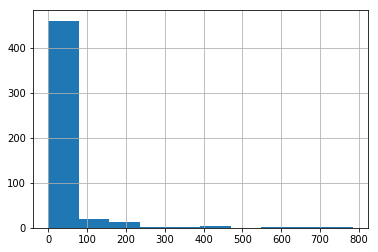

In [19]:
df1['Violent Crime'].hist()

In [20]:
df1.describe()

,Population,Violent Crime,Murder and Nonnegligent Manslaughter,Rape (legacy definition),Robbery,Aggravated Assault,Property Crime,Burglary,Larceny-Theft,Motor Vehicle Theft,Population^2,Murder,Robbery_binary
count,503.000,503.000,503.000,503.000,503.000,503.000,503.000,503.000,503.000,503.000,503.000,503.000,503.000
mean,14063.419,30.662,0.356,3.223,8.356,18.728,281.286,52.797,217.875,10.614,619201077.622,0.171,0.553
std,20548.985,76.705,1.228,6.745,26.270,48.713,467.816,107.588,353.066,24.877,2551686367.697,0.377,0.498
min,155.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,24025.000,0.000,0.000
25%,2122.000,2.000,0.000,0.000,0.000,1.000,28.000,5.000,20.000,0.000,4503173.000,0.000,0.000
50%,6775.000,10.000,0.000,1.000,1.000,6.000,111.000,18.000,78.000,3.000,45900625.000,0.000,1.000
75%,18199.000,25.000,0.000,4.000,5.000,16.000,354.500,51.500,276.500,10.000,331210657.000,0.000,1.000
max,200551.000,784.000,16.000,57.000,275.000,492.000,4415.000,1123.000,3098.000,283.000,40220703601.000,1.000,1.000


In [21]:
df1[df1['Violent Crime']>500]

,City,Population,Violent Crime,Murder and Nonnegligent Manslaughter,Rape (legacy definition),Robbery,Aggravated Assault,Property Crime,Burglary,Larceny-Theft,Motor Vehicle Theft,Population^2,Murder,Robbery_binary
17,Aurora,200551,601,4,53,119,425,2972,576,2285,111,40220703601,1,1
70,Champaign,82966,654,4,39,119,492,2275,506,1698,71,6883357156,1,1
232,Joliet,148462,557,10,49,158,340,3217,724,2337,156,22040965444,1,1
364,Peoria,115953,784,16,24,275,469,4415,1123,3098,194,13445098209,1,1


In [22]:
df1['Violent Crime'].describe()

count   503.000
mean     30.662
std      76.705
min       0.000
25%       2.000
50%      10.000
75%      25.000
max     784.000
Name: Violent Crime, dtype: float64